In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier, Pool, cv

from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [40]:
df = pd.read_csv('/kaggle/input/onion-or-not/OnionOrNot.csv')

In [3]:
df

,text,label
0,Entire Facebook Staff Laughs As Man Tightens P...,1
1,Muslim Woman Denied Soda Can for Fear She Coul...,0
2,Bold Move: Hulu Has Announced That They’re Gon...,1
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1
4,"For men looking for great single women, online...",1
...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1
23996,Connecticut TV station under fire after using ...,0
23997,Jurisprudence Fetishist Gets Off On Technicality,1
23998,Employees From Other Department Announce Plan ...,1


feature counts

In [4]:

print(df['text'].value_counts())


text
Area Satirical Publication The Onion Sold To Univision (Seriously)                                                                                                                                       2
Woman bites into ‘waferless’ KitKat, demands lifetime supply                                                                                                                                             2
Alex Jones Returns To Humble Roots Of Screaming Conspiracy Theories Through Megaphone At People In Park                                                                                                  1
The President Of Vice | ‘The Onion’ looks back on eight years of killer tuneage, knocking back tallboys, and hunting for trim with the most buck-fucking-wild hombre to ever work in the White House.    1
School Accidentally Tells Parents That All 717 Students Have Gone Missing                                                                                                              

Number of unique categories: 23998


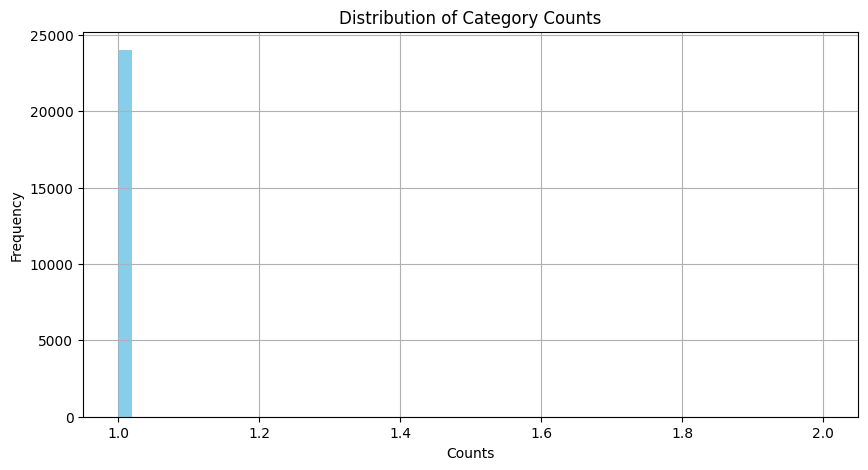

In [5]:

unique_categories = df['text'].nunique()
print(f"Number of unique categories: {unique_categories}")

category_counts = df['text'].value_counts()
category_counts.hist(bins=50, figsize=(10, 5), color='skyblue')
plt.title('Distribution of Category Counts')
plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.show()


so it has high cardinality : so using catboost classifier. Since catboost classifier works well with high cardinal datasets

Target encoder: for dealing with high cardinality

In [ ]:
# from category_encoders import TargetEncode
# encoder = TargetEncoder(cols=['text'])
# df['text_encoded'] = encoder.fit_transform(df['text'], df['label'])
# print(df[['text', 'text_encoded']].head())


Target encoding was not working well with the dataset. It was overfitiing. So didn't use it.

**Feature engineering**

In [ ]:

df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))


In [ ]:
df.head(5)

In [6]:

#  Sentence-BERT
model = SentenceTransformer('all-MiniLM-L6-v2')
df['embeddings'] = list(model.encode(df['text']))


Batches:   0%|          | 0/750 [00:00<?, ?it/s]

In [7]:
df

,text,label,embeddings
0,Entire Facebook Staff Laughs As Man Tightens P...,1,"[-0.019125253, 0.02034347, -0.026699297, 0.006..."
1,Muslim Woman Denied Soda Can for Fear She Coul...,0,"[-0.027597243, 0.1155847, -0.045793332, 0.0334..."
2,Bold Move: Hulu Has Announced That They’re Gon...,1,"[0.0035752584, -0.11526704, -0.008429253, -0.0..."
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1,"[-0.04443339, 0.0028044234, 0.053652283, 0.024..."
4,"For men looking for great single women, online...",1,"[-0.08598366, -0.06941988, 0.07413411, 0.06056..."
...,...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1,"[0.044982366, 0.08268456, 0.0017142069, 0.0187..."
23996,Connecticut TV station under fire after using ...,0,"[0.023299308, 0.020345481, 0.059252582, 0.0001..."
23997,Jurisprudence Fetishist Gets Off On Technicality,1,"[0.043437265, 0.0223586, -0.029668937, -0.0486..."
23998,Employees From Other Department Announce Plan ...,1,"[0.046424836, 0.05461104, 0.03712609, -0.00319..."


In [8]:

embeddings_df = pd.DataFrame(df['embeddings'].tolist(), columns=[f'embedding_{i}' for i in range(len(df['embeddings'][0]))])
df = pd.concat([df, embeddings_df], axis=1)
df.drop(columns=['embeddings'], inplace=True)

print(df.head()) 


                                                text  label  embedding_0  \
0  Entire Facebook Staff Laughs As Man Tightens P...      1    -0.019125   
1  Muslim Woman Denied Soda Can for Fear She Coul...      0    -0.027597   
2  Bold Move: Hulu Has Announced That They’re Gon...      1     0.003575   
3  Despondent Jeff Bezos Realizes He’ll Have To W...      1    -0.044433   
4  For men looking for great single women, online...      1    -0.085984   

   embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0     0.020343    -0.026699     0.006275     0.049215    -0.107043   
1     0.115585    -0.045793     0.033442     0.017903     0.019907   
2    -0.115267    -0.008429    -0.027351     0.007585     0.071784   
3     0.002804     0.053652     0.024170    -0.036791    -0.000919   
4    -0.069420     0.074134     0.060564    -0.018959     0.038215   

   embedding_6  embedding_7  ...  embedding_374  embedding_375  embedding_376  \
0     0.060885    -0.071838  ...       0.

In [9]:
df_r = df.drop(columns=['label','text'])

In [10]:
df_r

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
0,-0.019125,0.020343,-0.026699,0.006275,0.049215,-0.107043,0.060885,-0.071838,-0.028490,-0.069395,...,0.059251,-0.043020,0.014961,0.046427,-0.051474,0.008496,0.059822,0.015695,-0.052135,-0.011505
1,-0.027597,0.115585,-0.045793,0.033442,0.017903,0.019907,0.085071,-0.037580,-0.037901,-0.099107,...,0.007956,0.101614,0.027159,-0.036668,-0.035571,-0.045754,0.072686,-0.057766,0.086904,0.033534
2,0.003575,-0.115267,-0.008429,-0.027351,0.007585,0.071784,0.041070,-0.072250,0.005070,-0.072796,...,0.048454,0.011201,0.033379,-0.034333,-0.042007,0.026234,0.084243,-0.026049,0.023804,0.025962
3,-0.044433,0.002804,0.053652,0.024170,-0.036791,-0.000919,0.048854,-0.006365,0.009519,-0.022603,...,0.062988,-0.091578,-0.004735,0.021635,-0.162899,0.015407,0.007347,-0.069131,-0.019605,-0.051874
4,-0.085984,-0.069420,0.074134,0.060564,-0.018959,0.038215,-0.066634,0.048062,0.025586,-0.014347,...,0.038342,-0.062633,0.021595,0.094417,0.068065,0.034169,0.040215,-0.079046,-0.006618,0.027561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.044982,0.082685,0.001714,0.018739,0.065101,0.056390,-0.024760,-0.007120,0.045964,0.055907,...,0.123625,-0.040531,-0.057619,-0.023825,-0.118721,0.048232,0.054254,0.021600,0.048466,-0.042982
23996,0.023299,0.020345,0.059253,0.000125,0.054257,0.036342,-0.029011,-0.072468,-0.033414,-0.007940,...,0.015214,-0.059135,0.044364,0.032037,0.010398,0.098275,-0.034485,-0.021488,-0.008390,-0.007940
23997,0.043437,0.022359,-0.029669,-0.048654,-0.000353,-0.026340,0.103772,0.019718,-0.023122,0.011093,...,0.077863,-0.044044,0.086202,0.060056,-0.108076,-0.021685,0.024698,-0.001801,0.015325,-0.049166
23998,0.046425,0.054611,0.037126,-0.003199,0.011651,0.034253,0.002174,-0.048167,0.036573,-0.073839,...,0.064371,0.024292,-0.013307,-0.052039,-0.082185,-0.006251,-0.057731,0.009032,-0.009786,0.059590


In [11]:

target = 'label'
X = df_r
y = df[target]


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [24]:



#cross validation
train_pool = Pool(X_train, y_train)

params = {
    'iterations': 500,
    'depth': 6,
    'learning_rate': 0.1,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'task_type': 'GPU',
    'verbose': False
}

cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=False
)


best_fold_accuracy = cv_results['test-Accuracy-mean'].max()
print("Best Fold Accuracy:", best_fold_accuracy)

final_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    task_type='GPU',
    verbose=50
)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Training on fold [0/5]
bestTest = 0.8114583333
bestIteration = 431
Training on fold [1/5]
bestTest = 0.8052083333
bestIteration = 498
Training on fold [2/5]
bestTest = 0.815625
bestIteration = 497
Training on fold [3/5]
bestTest = 0.81015625
bestIteration = 420
Training on fold [4/5]
bestTest = 0.8169270833
bestIteration = 434
Best Fold Accuracy: 0.8105729166666666
0:	learn: 0.7036979	total: 58.2ms	remaining: 29.1s
50:	learn: 0.7985417	total: 2.88s	remaining: 25.4s
100:	learn: 0.8300521	total: 5.64s	remaining: 22.3s
150:	learn: 0.8495312	total: 8.36s	remaining: 19.3s
200:	learn: 0.8648958	total: 11.1s	remaining: 16.5s
250:	learn: 0.8780729	total: 13.8s	remaining: 13.6s
300:	learn: 0.8886458	total: 16.5s	remaining: 10.9s
350:	learn: 0.9001042	total: 19.1s	remaining: 8.12s
400:	learn: 0.9088542	total: 21.8s	remaining: 5.38s
450:	learn: 0.9178646	total: 24.5s	remaining: 2.66s
499:	learn: 0.9256250	total: 27.1s	remaining: 0us
Test Accuracy: 0.800625
Classification Report:
               pr

In [25]:
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)


        Feature Id  Importances
0    embedding_319     5.186198
1    embedding_223     2.960718
2    embedding_292     2.096529
3    embedding_131     1.863541
4     embedding_55     1.588862
..             ...          ...
380  embedding_214     0.000000
381  embedding_250     0.000000
382  embedding_285     0.000000
383  embedding_341     0.000000
384  embedding_360     0.000000

[385 rows x 2 columns]


Accruacy: 80%

                 precision    recall  f1-score   support

           0       0.82      0.87      0.85      3000
           1       0.76      0.68      0.72      1800


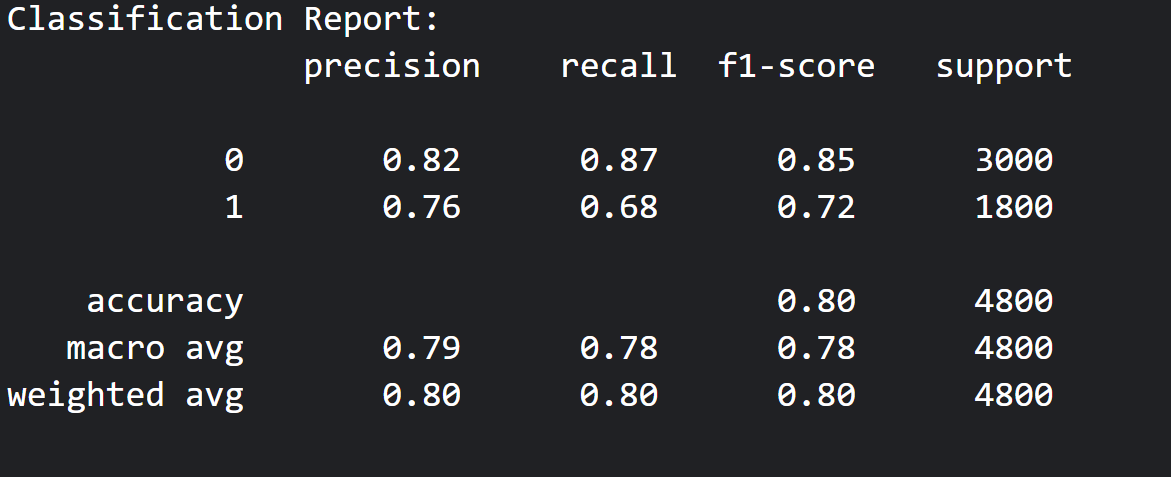

From classification report, it is evident that model finds difficult in minority class(label 1)

In [28]:


class_counts = Counter(y_train)  
total_samples = len(y_train)
num_classes = len(class_counts)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
class_weights_list = [class_weights[i] for i in sorted(class_weights.keys())]
print(class_weights_list)


[0.8, 1.3333333333333333]


In [29]:
model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    verbose=50,
    task_type="GPU",
    class_weights=class_weights_list  
)

model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


0:	learn: 0.6742529	test: 0.6756618	best: 0.6756618 (0)	total: 62.6ms	remaining: 31.2s
50:	learn: 0.4799906	test: 0.5178079	best: 0.5178079 (50)	total: 2.86s	remaining: 25.2s
100:	learn: 0.4289296	test: 0.4882325	best: 0.4882325 (100)	total: 5.63s	remaining: 22.2s
150:	learn: 0.3935727	test: 0.4743942	best: 0.4743942 (150)	total: 8.36s	remaining: 19.3s
200:	learn: 0.3665219	test: 0.4643718	best: 0.4643718 (200)	total: 11.1s	remaining: 16.5s
250:	learn: 0.3425941	test: 0.4573527	best: 0.4573527 (250)	total: 13.8s	remaining: 13.7s
300:	learn: 0.3223183	test: 0.4516958	best: 0.4516958 (300)	total: 16.5s	remaining: 10.9s
350:	learn: 0.3045711	test: 0.4482469	best: 0.4482469 (350)	total: 19.2s	remaining: 8.16s
400:	learn: 0.2872969	test: 0.4459298	best: 0.4459298 (400)	total: 21.9s	remaining: 5.42s
450:	learn: 0.2736758	test: 0.4430790	best: 0.4429818 (445)	total: 24.6s	remaining: 2.67s
499:	learn: 0.2605441	test: 0.4413216	best: 0.4411965 (497)	total: 27.3s	remaining: 0us
bestTest = 0.4411

Now, recall and f1 scores for class label 1 have increased. but overall accuracy doesn't have any effect. So more feature engineering is required

Accuracy: 80%


                precision    recall   f1-score   supportabsabs

           0       0.86      0.82      0.84      3000
           1       0.72      0.77      0.74      1800

Feature engineering : adding text polarity as a new column

In [30]:
from textblob import TextBlob
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


In [31]:
df

,text,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383,sentiment
0,Entire Facebook Staff Laughs As Man Tightens P...,1,-0.019125,0.020343,-0.026699,0.006275,0.049215,-0.107043,0.060885,-0.071838,...,-0.043020,0.014961,0.046427,-0.051474,0.008496,0.059822,0.015695,-0.052135,-0.011505,0.000000
1,Muslim Woman Denied Soda Can for Fear She Coul...,0,-0.027597,0.115585,-0.045793,0.033442,0.017903,0.019907,0.085071,-0.037580,...,0.101614,0.027159,-0.036668,-0.035571,-0.045754,0.072686,-0.057766,0.086904,0.033534,0.000000
2,Bold Move: Hulu Has Announced That They’re Gon...,1,0.003575,-0.115267,-0.008429,-0.027351,0.007585,0.071784,0.041070,-0.072250,...,0.011201,0.033379,-0.034333,-0.042007,0.026234,0.084243,-0.026049,0.023804,0.025962,-0.288889
3,Despondent Jeff Bezos Realizes He’ll Have To W...,1,-0.044433,0.002804,0.053652,0.024170,-0.036791,-0.000919,0.048854,-0.006365,...,-0.091578,-0.004735,0.021635,-0.162899,0.015407,0.007347,-0.069131,-0.019605,-0.051874,0.000000
4,"For men looking for great single women, online...",1,-0.085984,-0.069420,0.074134,0.060564,-0.018959,0.038215,-0.066634,0.048062,...,-0.062633,0.021595,0.094417,0.068065,0.034169,0.040215,-0.079046,-0.006618,0.027561,0.185714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,Teen Pregnancy Rate Prompting More High School...,1,0.044982,0.082685,0.001714,0.018739,0.065101,0.056390,-0.024760,-0.007120,...,-0.040531,-0.057619,-0.023825,-0.118721,0.048232,0.054254,0.021600,0.048466,-0.042982,0.065000
23996,Connecticut TV station under fire after using ...,0,0.023299,0.020345,0.059253,0.000125,0.054257,0.036342,-0.029011,-0.072468,...,-0.059135,0.044364,0.032037,0.010398,0.098275,-0.034485,-0.021488,-0.008390,-0.007940,0.000000
23997,Jurisprudence Fetishist Gets Off On Technicality,1,0.043437,0.022359,-0.029669,-0.048654,-0.000353,-0.026340,0.103772,0.019718,...,-0.044044,0.086202,0.060056,-0.108076,-0.021685,0.024698,-0.001801,0.015325,-0.049166,0.000000
23998,Employees From Other Department Announce Plan ...,1,0.046425,0.054611,0.037126,-0.003199,0.011651,0.034253,0.002174,-0.048167,...,0.024292,-0.013307,-0.052039,-0.082185,-0.006251,-0.057731,0.009032,-0.009786,0.059590,-0.109821


In [32]:
df_r = df.drop(columns=['label','text'])

target = 'label'
X = df_r
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    verbose=50,
    task_type="GPU",
    class_weights=class_weights_list  
)


model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


0:	learn: 0.6742529	test: 0.6756618	best: 0.6756618 (0)	total: 63.5ms	remaining: 31.7s
50:	learn: 0.4799906	test: 0.5178079	best: 0.5178079 (50)	total: 2.89s	remaining: 25.4s
100:	learn: 0.4289296	test: 0.4882325	best: 0.4882325 (100)	total: 5.67s	remaining: 22.4s
150:	learn: 0.3935727	test: 0.4743942	best: 0.4743942 (150)	total: 8.39s	remaining: 19.4s
200:	learn: 0.3665219	test: 0.4643718	best: 0.4643718 (200)	total: 11.1s	remaining: 16.6s
250:	learn: 0.3425941	test: 0.4573527	best: 0.4573527 (250)	total: 13.8s	remaining: 13.7s
300:	learn: 0.3223183	test: 0.4516958	best: 0.4516958 (300)	total: 16.5s	remaining: 10.9s
350:	learn: 0.3045711	test: 0.4482469	best: 0.4482469 (350)	total: 19.2s	remaining: 8.15s
400:	learn: 0.2872968	test: 0.4459298	best: 0.4459298 (400)	total: 21.9s	remaining: 5.41s
450:	learn: 0.2736758	test: 0.4430789	best: 0.4429818 (445)	total: 24.6s	remaining: 2.67s
499:	learn: 0.2605441	test: 0.4413216	best: 0.4411965 (497)	total: 27.2s	remaining: 0us
bestTest = 0.4411

In [33]:
feature_importances = model.get_feature_importance(prettified=True)
print(feature_importances)

        Feature Id  Importances
0    embedding_319     5.186198
1    embedding_223     2.960718
2    embedding_292     2.096529
3    embedding_131     1.863541
4     embedding_55     1.588862
..             ...          ...
380  embedding_214     0.000000
381  embedding_250     0.000000
382  embedding_285     0.000000
383  embedding_341     0.000000
384  embedding_360     0.000000

[385 rows x 2 columns]


No effect in adding polarity feature

Ensemble methods

In [45]:


catboost_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    task_type='GPU',
    verbose=50,
    class_weights=class_weights_list 
)

logreg_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)


ensemble = VotingClassifier(
    estimators=[
        ('catboost', catboost_model),
        ('logreg', logreg_model),
        ('rf', rf_model)
    ],
    voting='soft' 
)


ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_test)
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))


0:	learn: 0.6742528	total: 62.4ms	remaining: 31.2s
50:	learn: 0.4799907	total: 2.84s	remaining: 25s
100:	learn: 0.4289296	total: 5.57s	remaining: 22s
150:	learn: 0.3935727	total: 8.28s	remaining: 19.1s
200:	learn: 0.3665219	total: 11s	remaining: 16.3s
250:	learn: 0.3425942	total: 13.7s	remaining: 13.6s
300:	learn: 0.3223183	total: 16.3s	remaining: 10.8s
350:	learn: 0.3045711	total: 19s	remaining: 8.07s
400:	learn: 0.2872968	total: 21.7s	remaining: 5.36s
450:	learn: 0.2736758	total: 24.3s	remaining: 2.65s
499:	learn: 0.2605441	total: 27s	remaining: 0us
Ensemble Accuracy: 0.806875
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      3000
           1       0.72      0.79      0.75      1800

    accuracy                           0.81      4800
   macro avg       0.79      0.80      0.80      4800
weighted avg       0.81      0.81      0.81      4800



Ensemble Accuracy: **81%**


Classification Report:
                   precision    recall  f1-score   support

           0       0.87      0.82      0.84      3000
           1       0.72      0.79      0.75      1800

   
   

After ensemble methods, accuracy increased to 1%